<a href="https://colab.research.google.com/github/josdramo/AI-Project-SEST-Alert-System/blob/main/ML's_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Iniciando entrenamiento del Sistema de Alerta Temprana...
Entrenando Regresión Logística...
Entrenando SVM...
Entrenando KNN...
Entrenando Random Forest...
Entrenando XGBoost...

RANKING FINAL (Métrica Clave: AUC-ROC)
             Modelo  Accuracy  F1-Score  AUC-ROC
            XGBoost  0.748547  0.842801 0.735131
                SVM  0.807762  0.887414 0.717220
                KNN  0.652833  0.765176 0.697023
      Random Forest  0.658448  0.773226 0.684076
Regresión Logística  0.773083  0.865146 0.591553


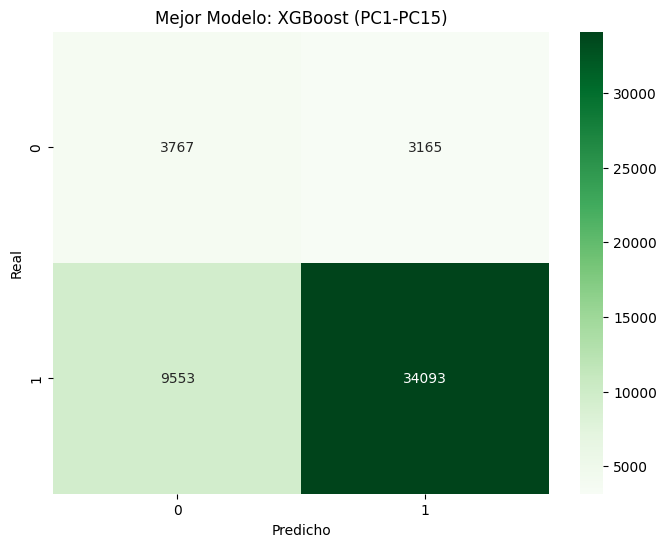


Predicciones guardadas exitosamente usando XGBoost.


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

# 1. Configuración de Entorno y Carga de Datos
drive.mount('/content/drive')
ruta = "/content/drive/MyDrive/Colab Notebooks/AI Project/"

# Cargamos los datasets finales (15 componentes PCA + SMOTE)
train_df = pd.read_csv(ruta + 'train_preprocesado_balanceado.csv')
test_df = pd.read_csv(ruta + 'test_preprocesado_2025.csv')

# 2. Preparación de Variables
features = [f'PC{i+1}' for i in range(15)]
X_train_full = train_df[features]
y_train_full = train_df['Target']

X_test = test_df[features]
y_test = test_df['Target']

# Muestreo para modelos de alta complejidad computacional (SVM y KNN)
X_train_sample, y_train_sample = resample(X_train_full, y_train_full, n_samples=25000, random_state=42, stratify=y_train_full)

# 3. Definición de Modelos (Sincronizado con Tarea 4)
modelos = {
    "Regresión Logística": (LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000), X_train_full, y_train_full),
    "SVM": (SVC(kernel='rbf', C=1.0, probability=True, random_state=42), X_train_sample, y_train_sample),
    "KNN": (KNeighborsClassifier(n_neighbors=5, weights='distance'), X_train_sample, y_train_sample),
    "Random Forest": (RandomForestClassifier(n_estimators=100, criterion='gini', random_state=42), X_train_full, y_train_full),
    "XGBoost": (XGBClassifier(n_estimators=5000, learning_rate=0.005, max_depth=3, eval_metric='logloss', random_state=42), X_train_full, y_train_full)
}

# 4. Entrenamiento y Evaluación Híbrida
resultados = []
print("Iniciando entrenamiento del Sistema de Alerta Temprana...")

for nombre, (modelo, X_ptr, y_ptr) in modelos.items():
    print(f"Entrenando {nombre}...")
    modelo.fit(X_ptr, y_ptr)

    y_pred = modelo.predict(X_test)
    y_prob = modelo.predict_proba(X_test)[:, 1]

    resultados.append({
        "Modelo": nombre,
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_prob)
    })

# 5. Visualización de Resultados y Guardado
df_res = pd.DataFrame(resultados).sort_values(by="AUC-ROC", ascending=False)
print("\n" + "="*50 + "\nRANKING FINAL (Métrica Clave: AUC-ROC)\n" + "="*50)
print(df_res.to_string(index=False))

# Matriz de Confusión del mejor modelo
mejor_mod_nombre = df_res.iloc[0]['Modelo']
mejor_modelo = modelos[mejor_mod_nombre][0]
y_pred_best = mejor_modelo.predict(X_test)

plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Greens')
plt.title(f'Mejor Modelo: {mejor_mod_nombre} (PC1-PC15)')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

# Exportar resultados finales para el Dashboard Territorial
test_df['Prob_Riesgo'] = mejor_modelo.predict_proba(X_test)[:, 1]
test_df['Pred_Riesgo'] = y_pred_best
test_df.to_csv(ruta + 'predicciones_finales_sest.csv', index=False)
print(f"\nPredicciones guardadas exitosamente usando {mejor_mod_nombre}.")

In [9]:
# --- SIMULADOR DE ALERTA TEMPRANA (INFERENCIA) ---
metadatos = ['codigo', 'amie', 'ciclo', 'grado', 'id_prov', 'id_cant']
ids_test = test_df[[c for c in metadatos if c in test_df.columns]]
# 1. Seleccionamos un estudiante al azar del conjunto de prueba (test_df)
# Usamos .iloc[[index]] para mantener el formato de tabla (DataFrame)
indice_estudiante = 1568  # Puedes cambiar este número
datos_estudiante = X_test.iloc[[indice_estudiante]]

# 2. El modelo analiza los 15 componentes PCA y predice
# 'mejor_modelo' es el que guardamos previamente (XGBoost o SVM)
probabilidad = mejor_modelo.predict_proba(datos_estudiante)[:, 1][0]
resultado_clase = mejor_modelo.predict(datos_estudiante)[0]

# 3. Rescatamos los metadatos para saber de quién hablamos
# (Usamos ids_test que definimos antes)
id_alumno = ids_test.iloc[indice_estudiante]['codigo']
provincia_id = ids_test.iloc[indice_estudiante]['id_prov']

# 4. Mostrar el Resultado Final
print(f"--- REPORTE DE EVALUACIÓN: Estudiante {id_alumno} ---")
print(f"Ubicación (ID Provincia): {provincia_id}")
print(f"Probabilidad de bajo logro académico: {probabilidad:.2%}")

if resultado_clase == 1:
    print("ESTADO: ⚠️ ALERTA DE RIESGO DETECTADA (Intervención Prioritaria)")
else:
    print("ESTADO: ✅ DESEMPEÑO ADECUADO (Sin Riesgo)")

--- REPORTE DE EVALUACIÓN: Estudiante DI6T602696 ---
Ubicación (ID Provincia): 1
Probabilidad de bajo logro académico: 57.82%
ESTADO: ⚠️ ALERTA DE RIESGO DETECTADA (Intervención Prioritaria)


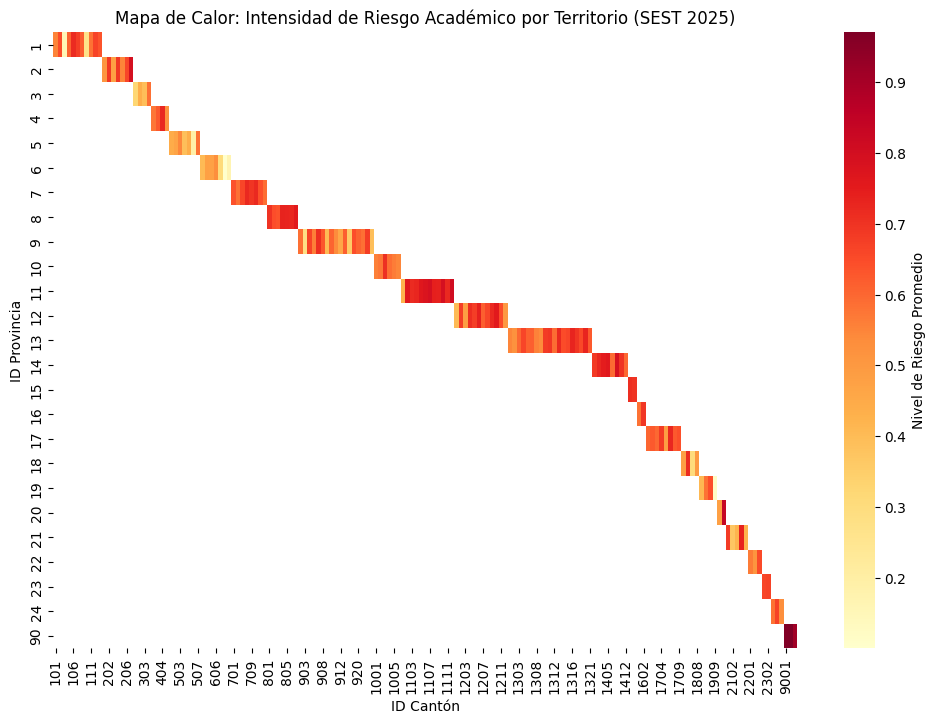

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Agrupar los datos por Provincia y Cantón para obtener el riesgo promedio
# Esto resume los 50,000 estudiantes en promedios por zona
mapa_data = test_df.groupby(['id_prov', 'id_cant'])['Prob_Riesgo'].mean().unstack()

# 2. Crear el Mapa de Calor
plt.figure(figsize=(12, 8))
sns.heatmap(mapa_data, cmap="YlOrRd", annot=False, cbar_kws={'label': 'Nivel de Riesgo Promedio'})

plt.title('Mapa de Calor: Intensidad de Riesgo Académico por Territorio (SEST 2025)')
plt.xlabel('ID Cantón')
plt.ylabel('ID Provincia')
plt.show()

In [ ]:
import geopandas as gpd
import pandas as pd
import folium

# 1. Cargar el shapefile provincial (Mucho más ligero)
path_prov = '/content/drive/MyDrive/Colab Notebooks/AI Project/GeoJSON Ecuador/Provincias/LIMITE_PROVINCIAL_CONALI_CNE_2022.shp'
mapa_prov = gpd.read_file(path_prov).to_crs(epsg=4326)

# 2. Cargar y procesar resultados a nivel PROVINCIAL
df_pred = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI Project/predicciones_finales_sest.csv')
riesgo_prov = df_pred.groupby('id_prov')['Prob_Riesgo'].mean().reset_index()

# Homologar ID (1 -> "01", 17 -> "17") para coincidir con 'CODPRO'
riesgo_prov['id_prov_str'] = riesgo_prov['id_prov'].apply(lambda x: str(int(x)).zfill(2))

# 3. Unir datos
mapa_final = mapa_prov.merge(riesgo_prov, left_on='CODPRO', right_on='id_prov_str', how='left')

# Llenar nulos con 0 para evitar errores en el mapa
mapa_final['Prob_Riesgo'] = mapa_final['Prob_Riesgo'].fillna(0)

# 4. Crear el mapa base
m = folium.Map(location=[-1.8312, -78.1834], zoom_start=7, tiles='cartodbpositron')

# 5. Capa Coroplética
cp = folium.Choropleth(
    geo_data=mapa_final,
    name='riesgo_educativo',
    data=riesgo_prov,
    columns=['id_prov_str', 'Prob_Riesgo'],
    key_on='feature.properties.CODPRO',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.5,
    legend_name='Riesgo Promedio de Bajo Logro (%)',
    highlight=True
).add_to(m)

# 6. TOOLTIP: Aquí es donde configuramos que se vea el nombre y el valor
# Creamos un formato amigable para la probabilidad (ej: 0.735 -> 73.5%)
mapa_final['Riesgo_Pct'] = (mapa_final['Prob_Riesgo'] * 100).round(2).astype(str) + '%'

folium.GeoJson(
    mapa_final,
    style_function=lambda x: {'fillColor': 'transparent', 'color': 'transparent'},
    tooltip=folium.GeoJsonTooltip(
        fields=['PROVINCIA', 'Riesgo_Pct'],
        aliases=['Provincia:', 'Riesgo Promedio:'],
        localize=True,
        sticky=False,
        labels=True
    )
).add_to(m)

# Guardar y mostrar
m.save('mapa_provincial_dinamico.html')
m

In [ ]:
import geopandas as gpd
import pandas as pd
import folium
from folium import plugins

# 1. Cargar el shapefile de cantones
path_cantones = '/content/drive/MyDrive/Colab Notebooks/AI Project/GeoJSON Ecuador/Cantones/LIMITE_CANTONAL_CONALI_CNE_2022.shp'
mapa_cantones = gpd.read_file(path_cantones)

# IMPORTANTE: Convertir a coordenadas geográficas (WGS84) para que Folium lo entienda
mapa_cantones = mapa_cantones.to_crs(epsg=4326)

# 2. Cargar y procesar tus datos de riesgo (Asegúrate de usar este nombre)
df_pred = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AI Project/predicciones_finales_sest.csv')

# Calculamos el riesgo por CANTÓN
riesgo_cantonal = df_pred.groupby('id_cant')['Prob_Riesgo'].mean().reset_index()

# Creamos la columna id_cant_str (RELLENO CON CEROS PARA 4 DÍGITOS)
riesgo_cantonal['id_cant_str'] = riesgo_cantonal['id_cant'].apply(lambda x: str(int(x)).zfill(4))

# 3. UNIÓN (MERGE) - CORRECCIÓN DE NOMBRES
# Verificamos qué columnas tiene tu shapefile para no fallar
print("Columnas en el Shapefile:", mapa_cantones.columns)
print("Columnas en Riesgo Cantonal:", riesgo_cantonal.columns)

# CAMBIO IMPORTANTE: Usamos 'riesgo_cantonal' en lugar de 'riesgo_provincial'
col_id_shp = 'CODCAN' # Asegúrate que esta columna exista en tu .shp tras ver el print de arriba

mapa_final = mapa_cantones.merge(
    riesgo_cantonal,
    left_on=col_id_shp,
    right_on='id_cant_str',
    how='left'
)

# 4. Crear el mapa base
m = folium.Map(location=[-1.8312, -78.1834], zoom_start=7, tiles='cartodbpositron')

# 5. Añadir la capa Coroplética Dinámica
cp = folium.Choropleth(
    geo_data=mapa_final,
    name='choropleth',
    data=riesgo_cantonal,
    columns=['id_cant_str', 'Prob_Riesgo'],
    key_on=f'feature.properties.{col_id_shp}',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Probabilidad de Riesgo Académico (%)',
    highlight=True
).add_to(m)

# 6. Añadir Tooltips Interactivos (Nombres de cantones al pasar el mouse)
folium.GeoJsonTooltip(
    fields=['CANTON', 'Prob_Riesgo'], # 'CANTON' debe ser el nombre de la columna en tu shp
    aliases=['Cantón: ', 'Riesgo Promedio: '],
    localize=True
).add_to(cp.geojson)

# 7. Guardar y mostrar
m.save('mapa_dinamico_sest_2025.html')
m